# Analysis of the Positive Dataset MMSeqs2 result

## Converting .fasta into pandas dataframe
Since the dataset is in .fasta format, we will first run a function that will convert it into a pandas dataframe.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:
## Reads the MMSeqs2 .fasta output of the positive dataset and then fills in the missing column values by extracting them from the original positive_dataset.fasta file via Accession IDs.
def fasta2df_positive_mmseqs(original_fasta, mmseqs2_fasta):
    """
    Reads .fasta files from the MMSeqs2 positive dataset output and its original positive dataset,
    then merges them together by filling in missing values from the original dataset using Accession IDs.

    Parameters:
    original_fasta (str): Path to the original .fasta file of the positive dataset.
    mmseqs2_fasta (str): Path to the MMSeqs2 .fasta output of the positive dataset.

    Returns:
    pd.DataFrame: DataFrame with columns:
        - 'ID': Accession IDs of the sequences.
        - 'Sequence': Corresponding protein sequences.
        - 'Organism': Organism information extracted from the sequence description.
        - 'Family': Family information extracted from the sequence description.
        - 'Type': Type information extracted from the sequence description.
        - 'Size': Length of the protein sequences or value extracted from metadata.
        - 'Protein Acr': Protein acronym extracted from the sequence description.
    """
    # Read the original fasta file to create a dictionary of accession ID and associated values
    original_data = {}
    for record in SeqIO.parse(original_fasta, 'fasta'):
        description = record.description
        accession_id = record.id
        # Use regular expressions to extract metadata
        matches = re.findall(r'(\w+)=([^=]+?)\s*(?=\w+=|$)', description)
        metadata = dict(matches)
        original_data[accession_id] = metadata

    # Read the mmseqs2 fasta file and try to assign missing values from the original fasta
    filled_data = []
    for record in SeqIO.parse(mmseqs2_fasta, 'fasta'):
        accession_id = record.id
        sequence = str(record.seq)
        metadata = original_data.get(accession_id, {})
        # Append the data to the list as a dictionary
        filled_data.append({'ID': accession_id, 
                            'Sequence': sequence, 
                            'Organism': metadata.get('Organism'), 
                            'Family': metadata.get('Family'), 
                            'Type': metadata.get('Type'), 
                            'Size': int(metadata.get('Size', 0)), 
                            'Protein Acr': metadata.get('ProteinAcr')})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(filled_data)

    # Sort the DataFrame alphabetically based on the "Organism" column
    df = df.sort_values(by='Organism')
    df = df.reset_index(drop=True) # Reset index
    
    return df

In [3]:
# For MMSeqs2 result of positive_dataset.fasta:
df_mmseqs = fasta2df_positive_mmseqs('positive_dataset.fasta', 'CDHIT_MMSeqs2_Files/positive_output_mmseqs.fasta')
df_mmseqs   # MMSeqs2 positive_dataset.fasta Output

,ID,Sequence,Organism,Family,Type,Size,Protein Acr
0,RGB60049.1,MSIYTDMIPAILLVNDPQDSLSGAPIENYVKVSNINVAIYKNDSFK...,Absiella sp.,AcrIIA8,II-A,105,Yes
1,WP_103240931.1,MSCPFQAMEGGNGMERKMALREFCGRYRKGDFKGTERAVQIEAGWY...,Acetatifactor muris,AcrIIA11,II-A,195,Yes
2,WP_086652143.1,MELIHTSDEVIKKIHKDGTFDTFLFFSASKYLAGSVASRKHYTYKI...,Acetobacter cibinongensis,AcrIF11,I-F,179,Yes
3,WP_012242545.1,MEKQQLLKDLIQAFNSGSFESSDVKVQIKAGWYDWFCKDSSLKNKT...,Acholeplasma laidlawii,AcrIIA11,II-A,144,Yes
4,WP_062681378.1,MQLFHTSPSEISTITSTGRFGSFLFFSARAYTMTAGEALVYSLEID...,Achromobacter denitrificans,AcrIF11,I-F,150,Yes
...,...,...,...,...,...,...,...
1101,WP_011192267.1,MNFGQALQALKAGYKVARIGWNGKGMFLILISGTKDVEPCEGTPYA...,Yersinia pseudotuberculosis,AcrIIA7,II-A,146,Yes
1102,AIN13836.1,MDSASSHGCGFVYTYEINDEKIASSRDLDNRTEEVYAFLRAELNID...,Yersinia pseudotuberculosis,AcrIF11,I-F,124,Yes
1103,WP_071704514.1,MNFGEALEAVKSGKKIARSGWNGAAQFVIKAGGYTVSEARPGSDYA...,Yersinia ruckeri,AcrIIA7,II-A,88,Yes
1104,CFQ72446.1,MKLFHGSYSSTAPVMQIGQFTQVNGSENLYDGIFASDSMDSASSHG...,Yersinia similis,AcrIF11,I-F,141,Yes


# MMSeqs2 Analysis

In [4]:
# Metrics for Sequence Size
print("min size:", df_mmseqs['Size'].min())         # Minimum of sequence size
print("max size:", df_mmseqs['Size'].max())         # Maximum of sequence size
print("mean:", round(df_mmseqs['Size'].mean()))     # Mean of sequence size
print("median:", int(df_mmseqs['Size'].median()))   # Median of sequence size
print("sd:", round(df_mmseqs['Size'].std(), 6))     # Standard Deviation of sequence size

min size: 47
max size: 528
mean: 121
median: 114
sd: 43.584775


In [5]:
# Defining an extra column "Genus"
df_mmseqs['Genus'] = df_mmseqs['Organism'].str.split().str[0]                       # Extracts the Genus of the Organism species name

# Creating a sub-dataframe with Genus names and Incidences of Genus names
genus_counts = df_mmseqs['Genus'].value_counts().reset_index()                      # Counts Genus occurrences
genus_counts.columns = ['Genus', 'Incidences']                                      # Renames columns

df_genus_incidences = genus_counts.sort_values(by='Genus').reset_index(drop=True)   # Creates a new DataFrame with Genus and Incidences columns
df_genus_incidences

,Genus,Incidences
0,Absiella,1
1,Acetatifactor,1
2,Acetobacter,1
3,Acholeplasma,1
4,Achromobacter,2
...,...,...
253,Xanthomonas,5
254,Xenophilus,1
255,Xenorhabdus,8
256,Yersinia,11


In [6]:
df_mmseqs.head()

,ID,Sequence,Organism,Family,Type,Size,Protein Acr,Genus
0,RGB60049.1,MSIYTDMIPAILLVNDPQDSLSGAPIENYVKVSNINVAIYKNDSFK...,Absiella sp.,AcrIIA8,II-A,105,Yes,Absiella
1,WP_103240931.1,MSCPFQAMEGGNGMERKMALREFCGRYRKGDFKGTERAVQIEAGWY...,Acetatifactor muris,AcrIIA11,II-A,195,Yes,Acetatifactor
2,WP_086652143.1,MELIHTSDEVIKKIHKDGTFDTFLFFSASKYLAGSVASRKHYTYKI...,Acetobacter cibinongensis,AcrIF11,I-F,179,Yes,Acetobacter
3,WP_012242545.1,MEKQQLLKDLIQAFNSGSFESSDVKVQIKAGWYDWFCKDSSLKNKT...,Acholeplasma laidlawii,AcrIIA11,II-A,144,Yes,Acholeplasma
4,WP_062681378.1,MQLFHTSPSEISTITSTGRFGSFLFFSARAYTMTAGEALVYSLEID...,Achromobacter denitrificans,AcrIF11,I-F,150,Yes,Achromobacter


In [7]:
print('Number of unique Organisms:', len(df_mmseqs['Organism'].unique()))
print('Number of unique Acr Families:', len(df_mmseqs['Family'].unique()))
print('Number of unique Acr Family Types:', len(df_mmseqs['Type'].unique()))
print('Number of unique Genera:', len(df_mmseqs['Genus'].unique()))

Number of unique Organisms: 633
Number of unique Acr Families: 126
Number of unique Acr Family Types: 18
Number of unique Genera: 258


# Protein Size by Genera (Top 50)

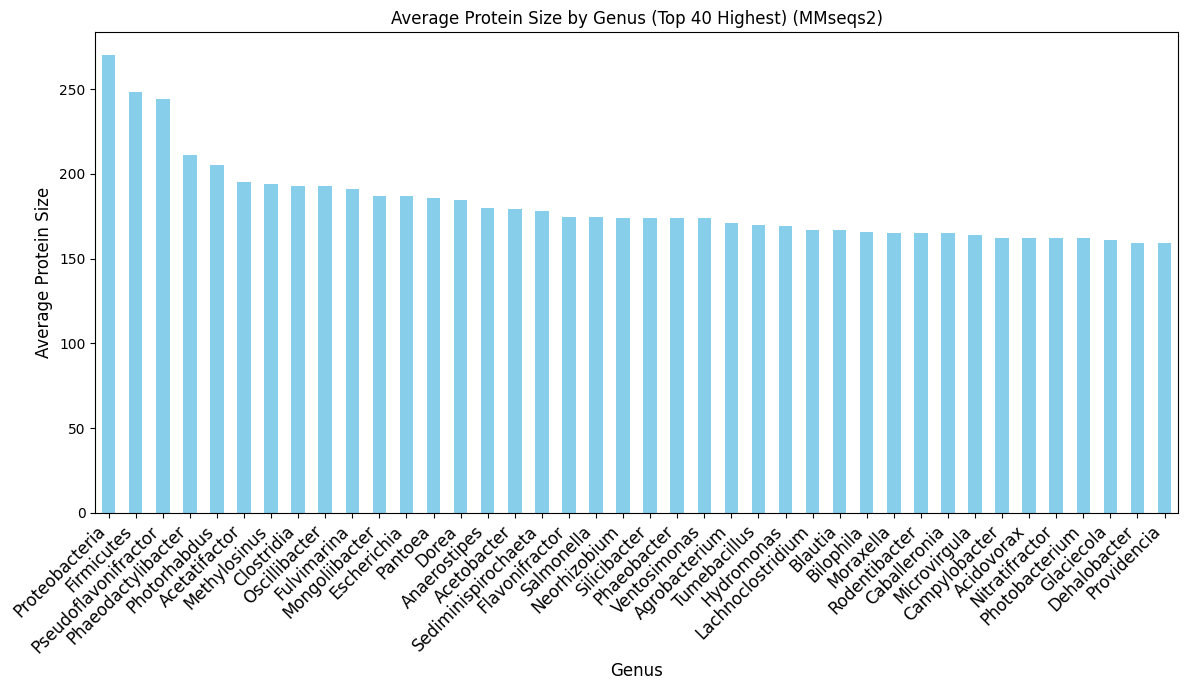

In [8]:
# Grouping by 'Genus' and calculating mean protein size for each genus
genus_mean_size = df_mmseqs.groupby('Genus')['Size'].mean().sort_values(ascending=False)

# Selecting the top 40 genera
top_genus_mean_size = genus_mean_size.head(40)

# Creating a bar plot
plt.figure(figsize=(12, 7))
top_genus_mean_size.plot(kind='bar', color='skyblue')
plt.title('Average Protein Size by Genus (Top 40 Highest) (MMseqs2)', fontsize=12)
plt.xlabel('Genus', fontsize=12)
plt.ylabel('Average Protein Size', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

### Principal Component Analysis (PCA)

### Protein Size by Genera (Top 50) where Genera that occur less than 5 times are colored in orange

The bars in orange represent the Genera which have less than 5 occurrences:


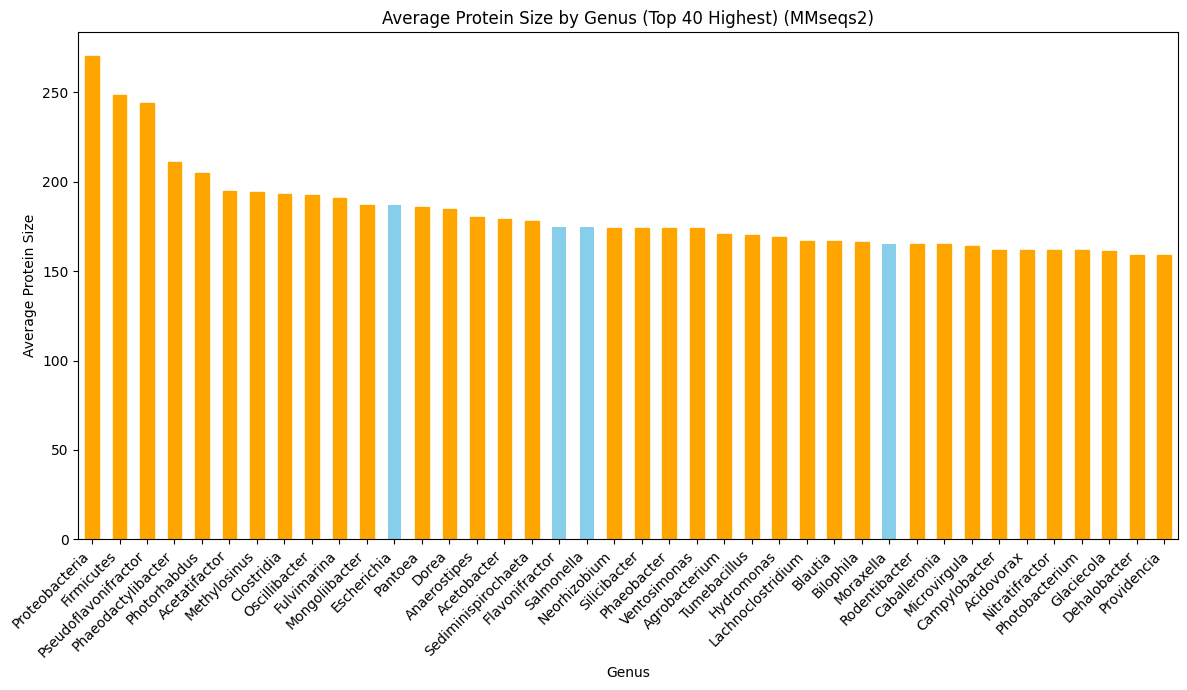

In [9]:
# Calculate mean size by genus
mean_size_by_genus = df_mmseqs.groupby('Genus')['Size'].mean()

# Get the top 40 genera by mean size
top_genus_mean_size = mean_size_by_genus.sort_values(ascending=False).head(40)

# Get genus counts
genus_counts = df_mmseqs['Genus'].value_counts()

# Creating a bar plot
plt.figure(figsize=(12, 7))
bars = top_genus_mean_size.plot(kind='bar', color='skyblue')

# Color genera occurring less than 5 times in orange
for bar in bars.patches:
    genus_name = top_genus_mean_size.index[bars.patches.index(bar)]
    if genus_counts[genus_name] < 5:
        bar.set_color('orange')

print('The bars in orange represent the Genera which have less than 5 occurrences:')
plt.title('Average Protein Size by Genus (Top 40 Highest) (MMseqs2)')
plt.xlabel('Genus')
plt.ylabel('Average Protein Size')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sequence Size by Genera that occur more than 5 times in the dataset (all cases)

The following is the average Sequence Size of ALL Genera that have more than 5 occurrences in the dataset:


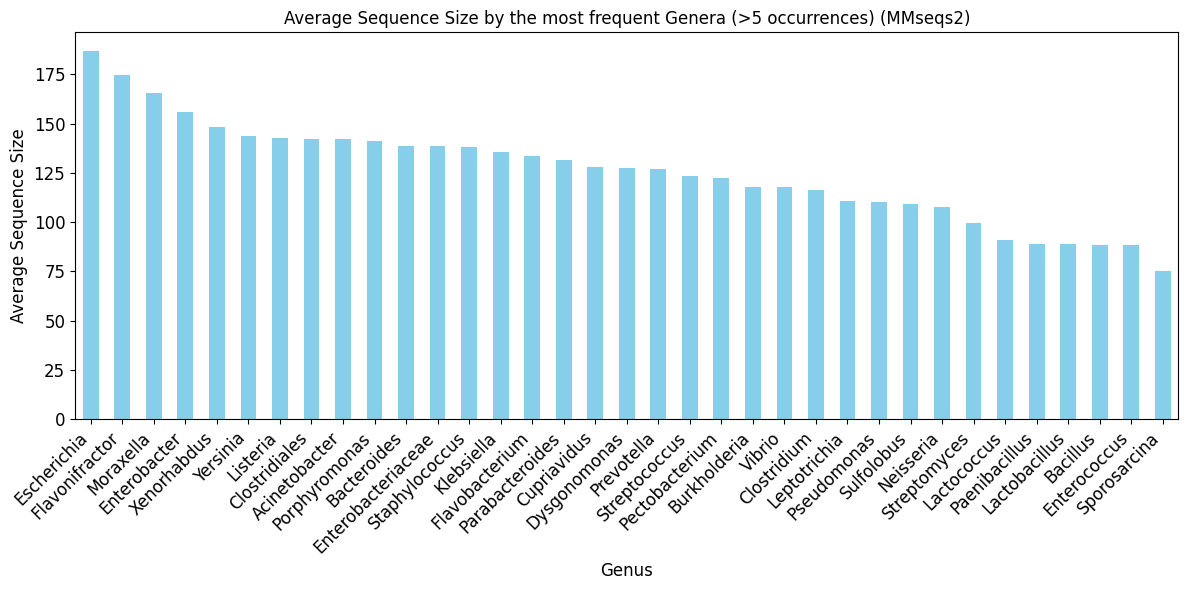

In [10]:
# Filter out genera with a frequency less than 5 counts
genus_counts = df_mmseqs['Genus'].value_counts()
valid_genus = genus_counts[genus_counts > 5].index
df_filtered = df_mmseqs[df_mmseqs['Genus'].isin(valid_genus)]

# Grouping by 'Genus' and calculating mean protein size for each genus
genus_mean_size = df_filtered.groupby('Genus')['Size'].mean().sort_values(ascending=False)

# Selecting all the genera
top_genus_mean_size = genus_mean_size.head(260)

# Creating a bar plot
print('The following is the average Sequence Size of ALL Genera that have more than 5 occurrences in the dataset:')
plt.figure(figsize=(12, 6))
top_genus_mean_size.plot(kind='bar', color='skyblue')
plt.title('Average Sequence Size by the most frequent Genera (>5 occurrences) (MMseqs2)')
plt.xlabel('Genus', fontsize=12)
plt.ylabel('Average Sequence Size', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Distribution of Sequence Sizes
Plot Type: Histogram
This plot will help us understand the distribution of the lengths of the Acr protein sequences.

The Average Sequence Length in the CD-HIT positive dataset is 121 aminoacids


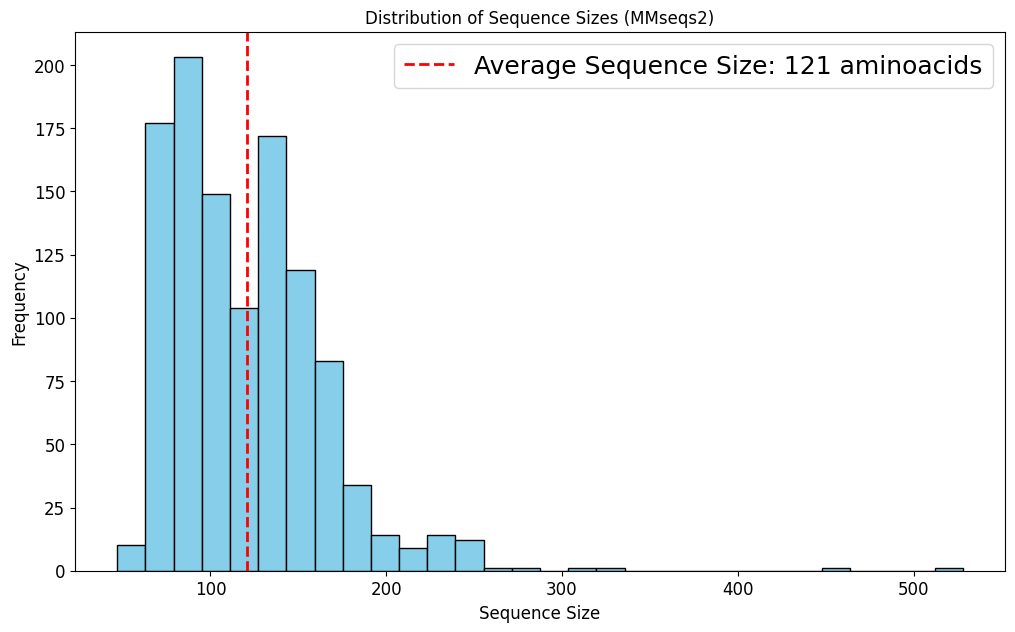

In [11]:
# Calculate the mean sequence size
mean_size = round(df_mmseqs['Size'].mean())

# Print the average sequence length
print(f'The Average Sequence Length in the CD-HIT positive dataset is {mean_size} aminoacids')

# Plotting
plt.figure(figsize=(12, 7))
plt.hist(df_mmseqs['Size'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_size, color='red', linestyle='--', linewidth=2, label=f'Average Sequence Size: {mean_size} aminoacids')
plt.title('Distribution of Sequence Sizes (MMseqs2)', fontsize=12)
plt.xlabel('Sequence Size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=18)
plt.show()

# Frequency of Genera

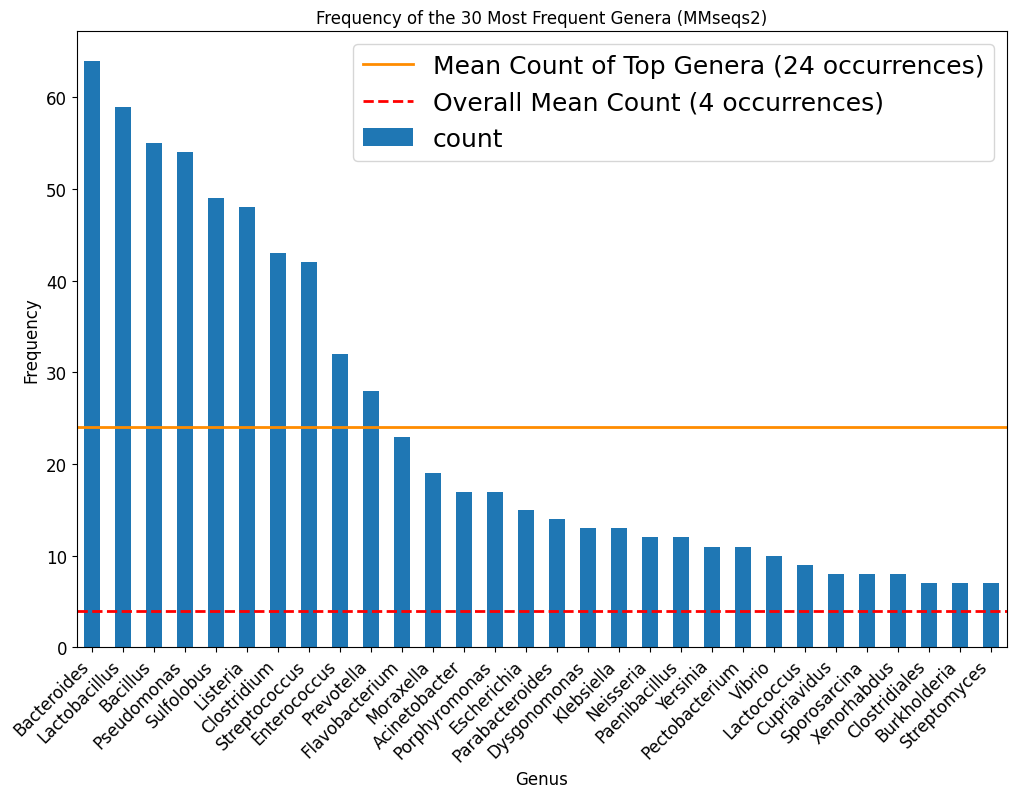

In [12]:
# Obtain genus counts
genus_counts = df_mmseqs['Genus'].value_counts()

# Get the top 30 most frequent genera
top_genera = genus_counts.head(30)

# Calculate the mean count of occurrences of all genera
overall_mean_count = round(genus_counts.mean())

# Calculate the mean count of occurrences of top genera
mean_count = round(top_genera.mean())

# Plot the data
plt.figure(figsize=(12, 8))
top_genera.plot(kind='bar')  # Use the default color for the bars
plt.axhline(y=mean_count, color='darkorange', linestyle='-', linewidth=2, label=f'Mean Count of Top Genera ({mean_count} occurrences)')
plt.axhline(y=overall_mean_count, color='red', linestyle='--', linewidth=2, label=f'Overall Mean Count ({overall_mean_count} occurrences)')
plt.title('Frequency of the 30 Most Frequent Genera (MMseqs2)', fontsize=12)
plt.xlabel('Genus', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels by 45 degrees and align them to the right
plt.yticks(fontsize=12)
plt.legend(fontsize=18)
plt.show()

# Sequence counts per Family

Number of unique Families: 126


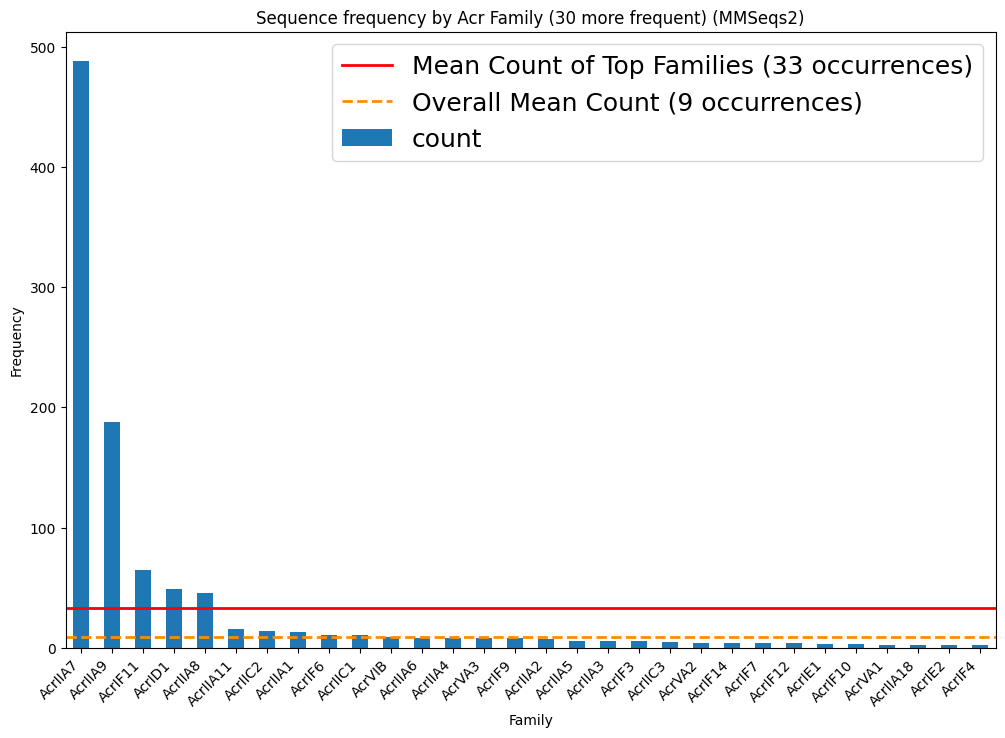

In [13]:
print('Number of unique Families:', len(df_mmseqs['Family'].unique()))

# Obtain Family counts
family_counts = df_mmseqs['Family'].value_counts()

# Get the top 30 most frequent families
top_family = family_counts.head(30)

# Calculate the mean count of occurrences of all families
overall_mean_count = round(family_counts.mean())

# Calculate the mean count of occurrences of top families
mean_count = round(top_family.mean())

# Plotting
plt.figure(figsize=(12, 8))
top_family.plot(kind='bar')
plt.axhline(y=mean_count, color='red', linestyle='-', linewidth=2, label=f'Mean Count of Top Families ({mean_count} occurrences)')
plt.axhline(y=overall_mean_count, color='darkorange', linestyle='--', linewidth=2, label=f'Overall Mean Count ({overall_mean_count} occurrences)')
plt.title('Sequence frequency by Acr Family (30 more frequent) (MMSeqs2)')
plt.xlabel('Family')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees and align them to the right
plt.legend(fontsize=18)
plt.show()